In [1]:
import glob
import os
import warnings
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

In [2]:
def get_results_dirs(
    dir_name: str,
    main_dir = "experiments"
):
    main_pattern = os.path.join(main_dir, dir_name, "*")
    dir_list = glob.glob(main_pattern)
    dir_list = sorted(dir_list)
    return dir_list

In [3]:
def load_metrics(strategies, results_dirs, max_it: int = 100):
    m_data = defaultdict(list)
    for d in results_dirs:
        metrics_files = {s: os.path.join(d, s) + '-metrics.csv' for s in strategies}
        for name, filename in metrics_files.items():
            try:
                data = pd.read_csv(filename, index_col=0)
                m_data[name].append(data.iloc[:max_it])
            except Exception:
                warnings.warn(f"Problem loading '{name}' from '{d}'")
                continue
    return m_data


In [4]:
def get_final_data(strategies: list[str], results_dirs: list[str]):
    final_data = defaultdict(list)
    for d in results_dirs:
        final_files = {s: os.path.join(d, s) + '-final.csv' for s in strategies}
        for name in strategies:
            try:
                if name == "VBMC":
                    f_data = pd.read_csv(os.path.join(d, 'VBMC-metrics.csv'), index_col=0)
                else:
                    f_data = pd.read_csv(final_files[name], index_col=0)
                final_data[name].append(f_data)
            except Exception as e:
                warnings.warn(f"Problem reading '{d}' for '{name}': {e}")
                continue

    for name in final_data.keys():
        final_data[name] = pd.concat(final_data[name], ignore_index=False)

    return final_data

In [5]:
method_names = {
    'FullGPRandomStrategy': 'Random',
    'FullGPIMSPEStrategy': 'IMSPE',
    'FullGPVariationalStrategy': 'BACON',
    'VBMC': 'VBMC',
    'FullGPEntropyStrategy': 'D-optimal'
    }
metric_fullnames = {
    'map_err': "MAP error",
    'RMSE': "Prediction RMSE",
    "KL_rev": "Reverse KL",
}
strategy_colors = {
    'FullGPRandomStrategy': 'b',
    'FullGPIMSPEStrategy': 'c',
    'FullGPVariationalStrategy': 'r',
    'FullGPEntropyStrategy': 'brown'
    }

start_idx = 1

def plot_metric_results(metric_name, metrics_data, smooth: bool = True, quantile_width: float = 0.8, alpha: float = 0.25, step: int = 1, start_t: int = 0, show_runs: bool = False, n_it: int = 100, use_std: bool = False):
    metric_results = dict.fromkeys(metrics_data.keys())
    for strategy_name, data_list in metrics_data.items():
        values = []
        for i, d in enumerate(data_list):
            if len(d[metric_name]) < n_it:
                continue
            else:
                dvals = d[metric_name].values[:n_it]
            values.append(dvals)
        values = np.vstack(values)
        metric_results[strategy_name] = values
    for name in metric_results.keys():
        values = metric_results[name][:, start_idx:]
        ts = np.arange(1, values.shape[-1] + 1)
        if smooth:
            avg_values = np.nancumsum(values, -1)/ts
        else:
            avg_values = values
        if use_std:
            main_values = avg_values.mean(0)
            avg_value_lcb = avg_values.mean(0) - 1 * avg_values.std(0)
            avg_value_ucb = avg_values.mean(0) + 1 * avg_values.std(0)
        else:
            main_values = np.median(avg_values, axis=0)
            avg_value_lcb = np.quantile(avg_values, quantile_width, axis=0)
            avg_value_ucb = np.quantile(avg_values, 1 - quantile_width, axis=0)
        plt.fill_between(start_t + ts * step, avg_value_lcb, avg_value_ucb, color=strategy_colors[name], alpha=alpha)
        plt.plot(start_t + ts * step, main_values, color=strategy_colors[name], label=method_names[name], lw=2)
        if show_runs:
            plt.plot(start_t + ts * step, avg_values.T, ls='--', color=strategy_colors[name], alpha=0.5)

    plt.title(metric_fullnames[metric_name])
    return metric_results


## Performance plots

In [ ]:
n_samples = 256
n_batch = 4
n_init = 20
prob_d = 2

problem_name = "synthetic1"             # in ['synthetic1', 'synthetic2', 'location']
experiments_dir = "data/paper_results"  # or, e.g., "experiments/"
results_dirs = get_results_dirs(problem_name, main_dir=experiments_dir)
if problem_name == "location":
    max_it = 30
else:
    max_it = 50

In [7]:
strategies = [
    'FullGPRandomStrategy',
    'FullGPIMSPEStrategy',
    'FullGPVariationalStrategy',
    'FullGPEntropyStrategy'
    ]

metrics_data = load_metrics(strategies, results_dirs)

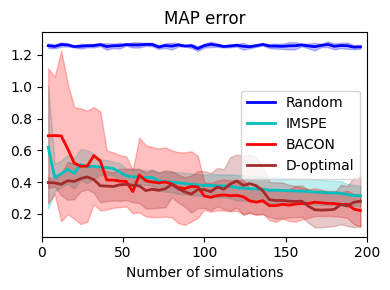

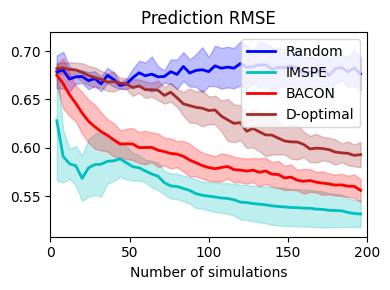

/Users/dos010/Projects/bacon-packaging/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


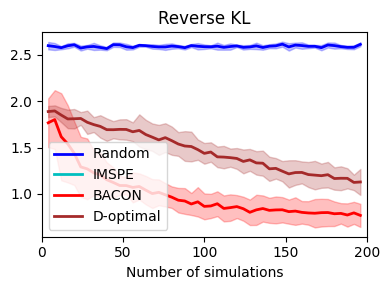

In [8]:
comparison_metrics = [
    'map_err',
    'RMSE',
    'KL_rev',
    ]

for metric_name in comparison_metrics:
    plt.figure(figsize=(4, 3))
    metric_results = plot_metric_results(metric_name, metrics_data, quantile_width=0.95, alpha=0.25, step=n_batch, n_it=max_it, smooth=False, use_std=True)
    plt.xlim(0, max_it * n_batch)
    plt.xlabel("Number of simulations")
    plt.legend()
    plt.tight_layout()
    plt.show()

## KL comparison table

In [9]:
strategies = [
    'FullGPVariationalStrategy',
    'FullGPIMSPEStrategy',
    'FullGPEntropyStrategy',
    'FullGPRandomStrategy',
    ]

final_data = defaultdict(list)
for d in results_dirs:
    metrics_files = {s: os.path.join(d, s) + '-metrics.csv' for s in strategies}
    final_files = {s: os.path.join(d, s) + '-final.csv' for s in strategies}
    kl_file = os.path.join(d, "KL.csv")
    if os.path.exists(kl_file):
        kl_data = pd.read_csv(kl_file, index_col=0)
    else:
        kl_data = None
    for name in strategies:
        try:
            if kl_data is None:
                f_data = pd.read_csv(final_files[name], index_col=0)
                if f_data.ndim > 1:
                    f_data = f_data.iloc[-1]
            else:
                f_data = kl_data[name]
            final_data[name].append(f_data)
        except FileNotFoundError:
            continue

for name in final_data.keys():
    final_data[name] = pd.DataFrame.from_records(final_data[name])

In [10]:
vbmc_data = []

for d in results_dirs:
    try:
        data = pd.read_csv(os.path.join(d, 'VBMC-metrics.csv'), index_col=0)
        vbmc_data.append(data)
    except FileNotFoundError:
        warnings.warn(f"VBMC results not found at: '{d}'")
final_data['VBMC'] = pd.concat(vbmc_data, ignore_index=True).rename(columns={"KL_q_to_true": "KL_final_to_true"})

In [11]:
metric_names = [
    'KL_final_to_initial',
    'KL_final_to_true',
    ]
table_names = {
    'KL_final_to_true': r'$\kl{p_T}{p^*} \downarrow$',
    'KL_final_to_initial': r'$\kl{p_T}{p_0} \uparrow$'
    }
def make_table_data(final_data):
    table_data = defaultdict(dict)
    for metric_name in metric_names:
        formatted_name = table_names[metric_name]
        for name, data in final_data.items():
            try:
                values = final_data[name][metric_name]
                method_name = method_names[name]
                finite_idx = np.isfinite(values)
                n_finite = finite_idx.sum()
                if n_finite < len(values):
                    warnings.warn(f"{n_finite} finite values out of {len(values)} for '{name}'/'{metric_name}'")
                m = values[finite_idx].mean()
                if np.isfinite(m):
                    table_data[formatted_name][method_name] = rf"{m:.02f} $\pm$ {values[finite_idx].std():.02f}"
                else:
                    table_data[formatted_name][method_name] = r"--"
            except KeyError:
                warnings.warn(f"Missing {metric_name}, {name}")
                method_name = method_names[name]
                table_data[formatted_name][method_name] = r"--"
                continue
    return pd.DataFrame(table_data)

In [12]:
table_df = make_table_data(final_data)
table_df

/var/folders/88/jxprjvjx41s98ssgh5rdm2k40000gp/T/ipykernel_59011/1866552075.py:27: UserWarning: Missing KL_final_to_initial, VBMC
  warnings.warn(f"Missing {metric_name}, {name}")


,$\kl{p_T}{p_0} \uparrow$,$\kl{p_T}{p^*} \downarrow$
BACON,1.00 $\pm$ 0.06,0.76 $\pm$ 0.13
IMSPE,0.89 $\pm$ 0.11,1.05 $\pm$ 0.19
D-optimal,0.42 $\pm$ 0.11,1.09 $\pm$ 0.15
Random,0.62 $\pm$ 0.07,1.18 $\pm$ 0.13
VBMC,--,0.53 $\pm$ 0.02


## Reference posteriors for synthetic problems

In [13]:
def plot_samples(
    samples: torch.Tensor,
    true_theta: torch.Tensor | None = None,
    show: bool = True,
    lower: float = -3.0,
    upper: float = 3.0,
    **hist_kwargs,
):
    samples = samples.detach().cpu().numpy()
    if true_theta is not None:
        true_theta = true_theta.detach().cpu().numpy()
    if samples.shape[-1] == 1:
        if lower is not None and upper is not None:
            hist_range = (lower, upper)
        else:
            hist_range = None
        plt.hist(samples.ravel(), density=True, range=hist_range, **hist_kwargs)
        if true_theta is not None:
            plt.axvline(true_theta.item(), ls="--", c="r")
    elif samples.shape[-1] == 2:
        if lower is not None and upper is not None:
            if hasattr(lower, "__len__"):
                hist_range = [[lower[0], upper[0]], [lower[1], upper[1]]]
            else:
                hist_range = [[lower, upper], [lower, upper]]
        else:
            hist_range = None
        plt.hist2d(
            samples[:, 0], samples[:, 1], density=True, range=hist_range, **hist_kwargs
        )
        if true_theta is not None:
            plt.plot(
                true_theta[..., 0], true_theta[..., 1], "w*", ms=20, mew=1, mec="k"
            )
    else:
        raise ValueError("Only available for 1D or 2D plots")
    if show:
        plt.show()


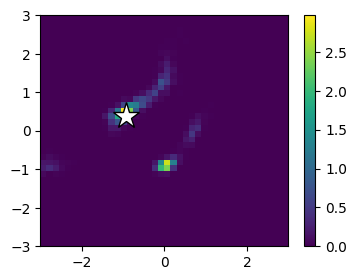

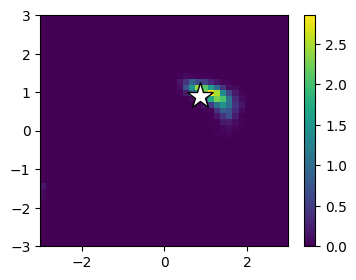

In [14]:
data_dir = "data/fixed_problems"
for fixed_problem_dir in os.listdir(data_dir):
    posterior_samples = torch.load(os.path.join(data_dir, fixed_problem_dir, "posterior_samples.pth"), map_location="cpu")
    problem = torch.load(os.path.join(data_dir, fixed_problem_dir, "problem.pth"), map_location="cpu")
    plt.figure(figsize=(4,3))
    plot_samples(posterior_samples, true_theta=problem.true_parameters, bins=40, show=False)
    plt.colorbar()
    plt.show()
